In [23]:
import netwulf as nw
import networkx as nx
import urllib.request
import json
import pandas as pd
import re
import pickle
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
from nltk.corpus import PlaintextCorpusReader
import urllib.parse
from nltk import word_tokenize
import nltk, re, pprint
import matplotlib_inline
%matplotlib inline
import pickle
from wordcloud import WordCloud
from collections import Counter
import community.community_louvain as community
import math
import powerlaw
import collections
import scipy
import squarify
import seaborn as sb
from nltk.corpus import stopwords
import matplotlib.patches as mpatches
import shutil
nltk.download("stopwords")
lemmatizer = nltk.stem.WordNetLemmatizer()
import random

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load graph from make graph

In [24]:
# Load graph from a pickle file
with open("LargeData/Graph_all.pkl", "rb") as file:
    G = pickle.load(file)

# Make GCC
UG = G.to_undirected()

# Basic statistics
Main responsible Clair

In [25]:
print('Number of nodes: ',G.number_of_nodes())
print('Number of edges: ',G.number_of_edges())

Number of nodes:  45044
Number of edges:  880399


In [26]:
print('Number of multiedges: ',len([x for x in G.edges() if G.number_of_edges(x[0],x[1]) > 1]))

Number of multiedges:  381805


In the following plots of degree distributions are shown

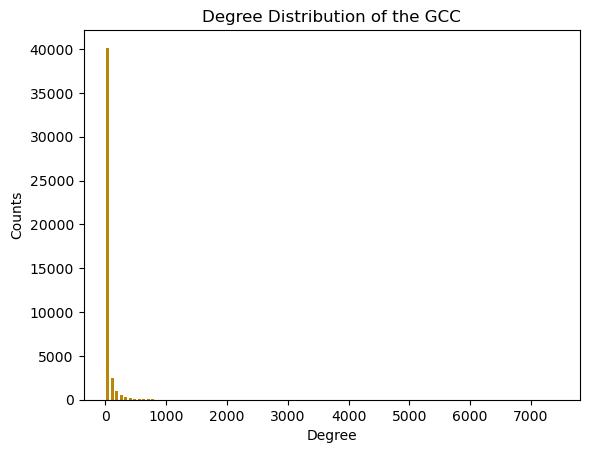

In [27]:
degree_sequence = [d for n, d in G.degree()]
bins = np.histogram(degree_sequence,bins=100)
loc = []
for i in range(len(bins[1])-1):
    loc.append((bins[1][i]+bins[1][i+1])/2)

# Plot
plt.figure()
plt.bar(loc,bins[0],color='darkgoldenrod',width=50)
plt.title('Degree Distribution of the GCC')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.show()

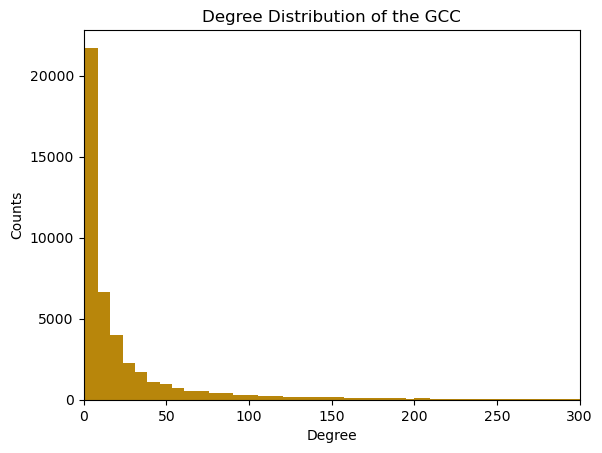

In [28]:
# Plot degree distribution with less than 1000 degrees
bins = np.histogram(degree_sequence,bins=1000)
loc = []
for i in range(len(bins[1])-1):
    loc.append((bins[1][i]+bins[1][i+1])/2)
plt.figure()
plt.bar(loc,bins[0],color='darkgoldenrod',width=10)
plt.title('Degree Distribution of the GCC')
plt.xlabel('Degree')
plt.ylabel('Counts')
plt.xlim(0,300)
plt.show()

Node with highest degree

In [29]:
# Find node with highest degree
max_degree = 0
max_degree_node = None
for node in G.nodes():
    if G.degree(node) > max_degree:
        max_degree = G.degree(node)
        max_degree_node = node

print('Node with highest degree: ',max_degree_node,' with degree: ',max_degree)

Node with highest degree:  Lastrevio  with degree:  7442


Flair of that node

In [30]:
# Print flair of node with highest degree
print('Flair of node with highest degree: ',G.nodes[max_degree_node]['flair'])

Flair of node with highest degree:  intp


In [31]:
# Get number of counts for each flair
flairs = [G.nodes[node]['flair'] for node in G.nodes()]
flairs_counter = Counter(flairs)
flair_list=list(flairs_counter.keys())

Comparison of flair distribution in the world (estimated, source: https://typologytriad.wordpress.com/mbti-population-by-country/) versus flair distribution on reddit

In [32]:
world_flairs_dict= {"istj": 17,
                    "istp": 9.5,
                    "estp": 7,
                    "estj": 13,
                    "isfj": 7,
                    "isfp": 5.5,
                    "esfp": 5,
                    "esfj": 5,
                    "infj": 2,
                    "infp": 5,
                    "enfp": 6.5,
                    "enfj": 2.5,
                    "intj": 3.5,
                    "intp": 4.5,
                    "entp": 4,
                    "entj": 3}

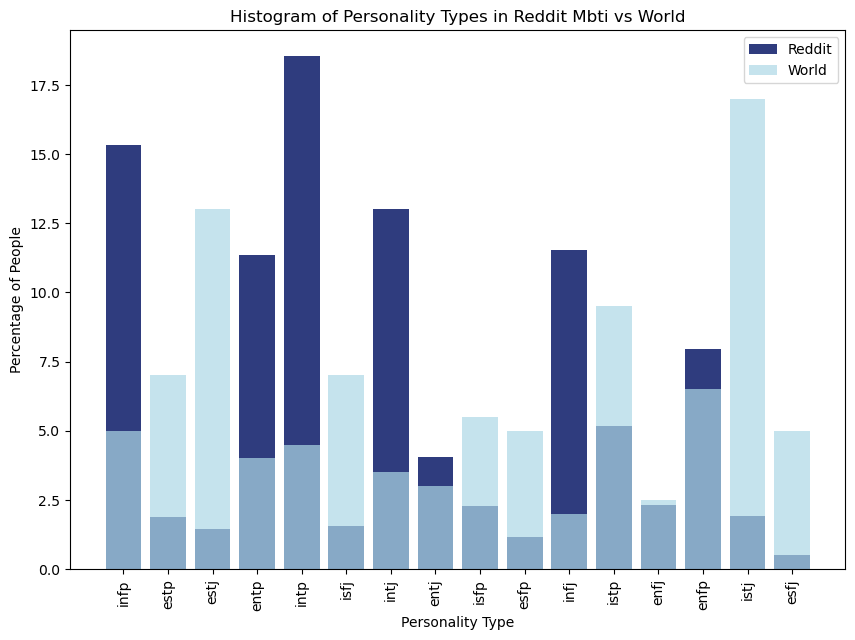

In [33]:


flair_list=list(flairs_counter.keys())
flairs = [flairs_counter[x] for x in flair_list]
flairs /= np.sum(flairs)
flairs = [x*100 for x in flairs]

world_flairs = [world_flairs_dict[x] for x in flair_list]

# Plot
plt.figure(figsize=(10,7))
plt.bar(np.arange(16)-0.4,flairs,color='#2F3C7E',width=0.8,label='Reddit')
plt.bar(np.arange(16)-0.4,world_flairs,color='#ADD8E6',width=0.8,alpha=0.7,label='World')
plt.title('Histogram of Personality Types in Reddit Mbti vs World')
plt.xticks(np.arange(16)-0.4,flairs_counter.keys(),rotation=90)
plt.xlabel('Personality Type')
plt.ylabel('Percentage of People')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Comparison of flair distribution on r/mbti and each subreddit of a flair, data was found be typing each type into reddit and compere with the number of users in their subreddit all numbers are in thousands

In [34]:
subreddit_flairs_dict= {"istj": 21.6,
                    "istp": 36.6,
                    "estp": 10.6,
                    "estj": 5.7,
                    "isfj": 20.4,
                    "isfp": 26.7,
                    "esfp": 9.4,
                    "esfj": 7.8,
                    "infj": 169,
                    "infp": 217,
                    "enfp": 99.7,
                    "enfj": 33.9,
                    "intj": 163,
                    "intp": 186,
                    "entp": 75.9,
                    "entj": 36.1}

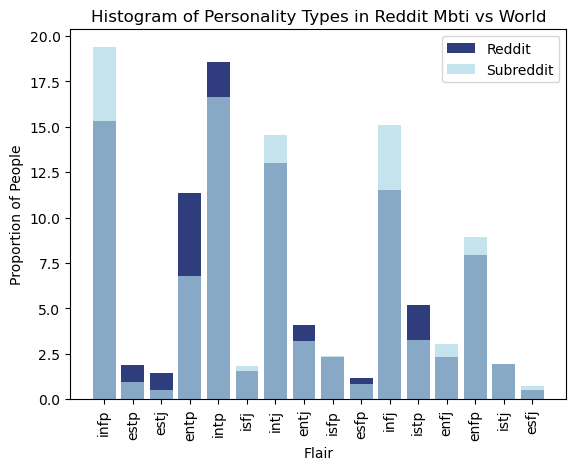

In [35]:
subreddit_flairs = [subreddit_flairs_dict[x] for x in flair_list]
subreddit_flairs =subreddit_flairs/ np.sum(subreddit_flairs)*100

# Plot
plt.figure()
plt.bar(np.arange(16)-0.4,flairs,color='#2F3C7E',width=0.8,label='Reddit')
plt.bar(np.arange(16)-0.4,subreddit_flairs,color='#ADD8E6',width=0.8,alpha=0.7,label='Subreddit')
plt.title('Histogram of Personality Types in Reddit Mbti vs World')
plt.xticks(np.arange(16)-0.4,flairs_counter.keys(),rotation=90)
plt.xlabel('Flair')
plt.ylabel('Proportion of People')
plt.xticks(rotation=90)
plt.legend()
plt.show()

Comparison of in and out degree vs total degree on both linear and log-scale

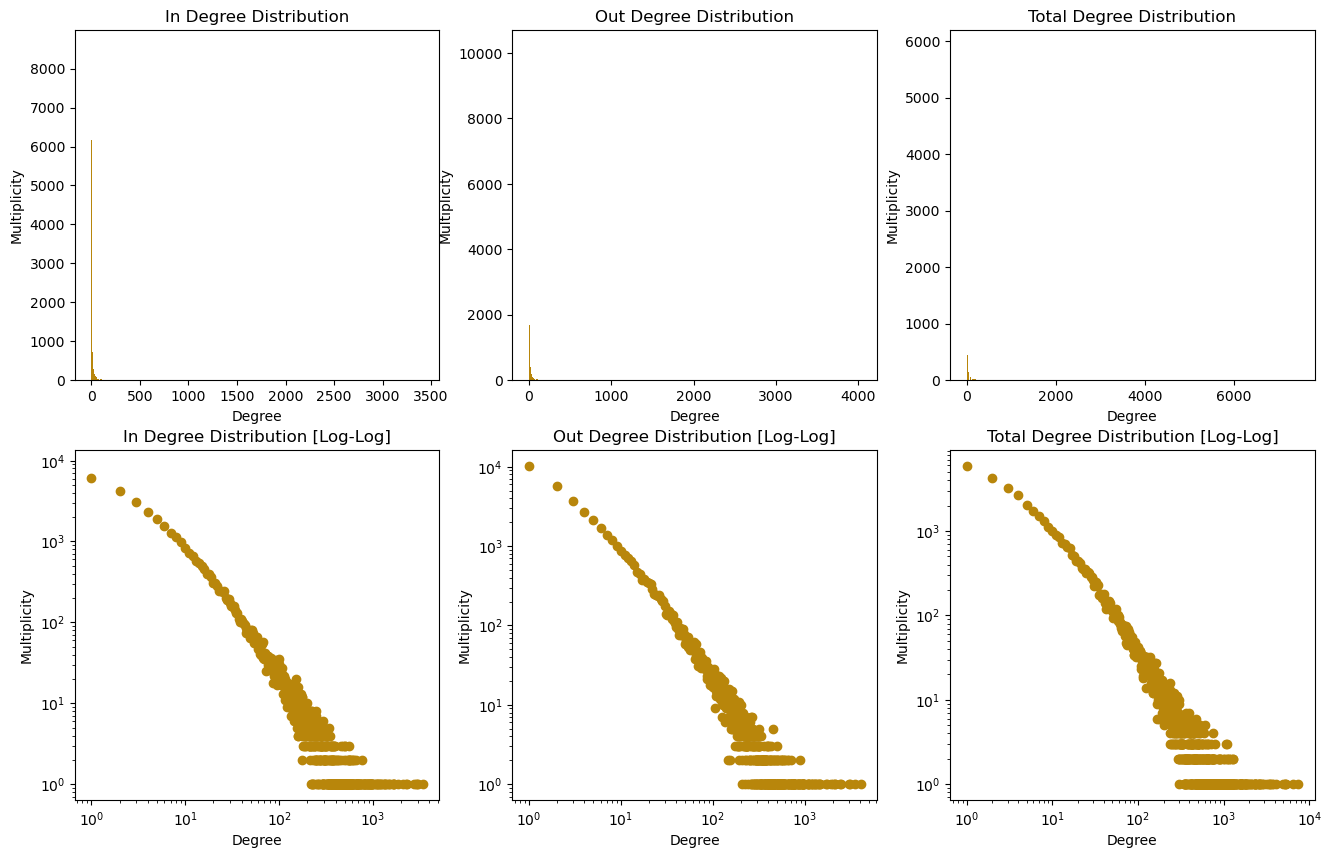

In [36]:
#Plot degree distribution of the  graph
fig,ax = plt.subplots(2,3,figsize=(16,10))

in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence
in_degreeCount = collections.Counter(in_degree_sequence)

ax[0,0].bar(in_degreeCount.keys(), in_degreeCount.values(), color='darkgoldenrod')
ax[0,0].set_title("In Degree Distribution")
ax[0,0].set_ylabel("Multiplicity")
ax[0,0].set_xlabel("Degree")
ax[1,0].loglog(in_degreeCount.keys(), in_degreeCount.values(), color='darkgoldenrod',marker="o",linestyle="None")
ax[1,0].set_title("In Degree Distribution [Log-Log]")
ax[1,0].set_ylabel("Multiplicity")
ax[1,0].set_xlabel("Degree")

out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  # degree sequence
out_degreeCount = collections.Counter(out_degree_sequence)

ax[0,1].bar(out_degreeCount.keys(), out_degreeCount.values(), color='darkgoldenrod')
ax[0,1].set_title("Out Degree Distribution")
ax[0,1].set_ylabel("Multiplicity")
ax[0,1].set_xlabel("Degree")
ax[1,1].loglog(out_degreeCount.keys(), out_degreeCount.values(), color='darkgoldenrod',marker="o",linestyle="None")
ax[1,1].set_title("Out Degree Distribution [Log-Log]")
ax[1,1].set_ylabel("Multiplicity")
ax[1,1].set_xlabel("Degree")

degree_distribution = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount=collections.Counter(degree_distribution)

ax[0,2].bar(degreeCount.keys(), degreeCount.values(), color='darkgoldenrod')
ax[0,2].set_title("Total Degree Distribution")
ax[0,2].set_ylabel("Multiplicity")
ax[0,2].set_xlabel("Degree")
ax[1,2].loglog(degreeCount.keys(), degreeCount.values(), color='darkgoldenrod',marker="o",linestyle="None")
ax[1,2].set_title("Total Degree Distribution [Log-Log]")
ax[1,2].set_ylabel("Multiplicity")
ax[1,2].set_xlabel("Degree")

plt.show()

Compute the exponent of the power law for the in, out and total degree.

In [37]:
in_degree_sequence = np.array(in_degree_sequence)
in_degree_sequence = in_degree_sequence[in_degree_sequence!=0]
results=powerlaw.Fit(in_degree_sequence)
print(f"The exponent for in-degree is: {results.power_law.alpha}")

Calculating best minimal value for power law fit


The exponent for in-degree is: 2.8445579446496954


In [38]:
out_degree_sequence = np.array(out_degree_sequence)
out_degree_sequence = out_degree_sequence[out_degree_sequence!=0]
out_degree_sequence = out_degree_sequence[out_degree_sequence!=np.nan]

results=powerlaw.Fit(out_degree_sequence)
print(f"The exponent for out-degree is: {results.power_law.alpha}")

The exponent for out-degree is: 3.1199458239216202


Calculating best minimal value for power law fit


In [39]:
degree_sequence = np.array(degree_sequence)
degree_sequence = degree_sequence[degree_sequence!=0]
degree_sequence = degree_sequence[degree_sequence!=np.nan]

results=powerlaw.Fit(degree_sequence)
print(f"The exponent for degree is: {results.power_law.alpha}")

Calculating best minimal value for power law fit


The exponent for degree is: 2.6967787722407612


In [40]:
#Compare to random graph
N=len(G.nodes)
p=2*len(G.edges)/(N*(N-1))

random_graph=nx.erdos_renyi_graph(N,p,directed=False,seed=42)
degree_sequence = sorted([d for n, d in random_graph.degree()], reverse=True)  # degree sequence
degree_sequence = np.array(degree_sequence)
degree_sequence = degree_sequence[degree_sequence!=0]
degreeCount = collections.Counter(in_degree_sequence)
results=powerlaw.Fit(degree_sequence)
print(f"The exponent for a random graph is {results.power_law.alpha}")

The exponent for a random graph is 23.6932500676449


Calculating best minimal value for power law fit


In [41]:
#nw.visualize(G)

In [42]:
# Create a random representative subset of 1000 nodes
GSUB = nx.subgraph(G,np.random.choice(G.nodes,1000,replace=False))
#GSUB = nx.subgraph(GSUB,max(nx.weakly_connected_components(GSUB), key=len)) # GCC
UG = GSUB.to_undirected()

In [43]:
# Define node size by degree
node_sizes = []
for node in UG.nodes():
    node_sizes.append(30)
    #node_sizes.append(UG.degree[node]*10)

# Define node color by flair
flair_colors = {
    'intj': 'red',
    'intp': 'blue',
    'entj': 'green',
    'entp': 'brown',
    'infj': 'orange',
    'infp': 'black',
    'enfj': 'purple',
    'enfp': 'pink',
    'istj': 'cyan',
    'isfj': 'yellow',
    'estj': 'black',
    'esfj': 'darkgoldenrod',
    'istp': 'chocolate',
    'isfp': 'lime',
    'estp': 'cornflowerblue',
    'esfp': 'turquoise',
}

node_colors = [flair_colors[UG.nodes[node]['flair']] for node in UG.nodes()]

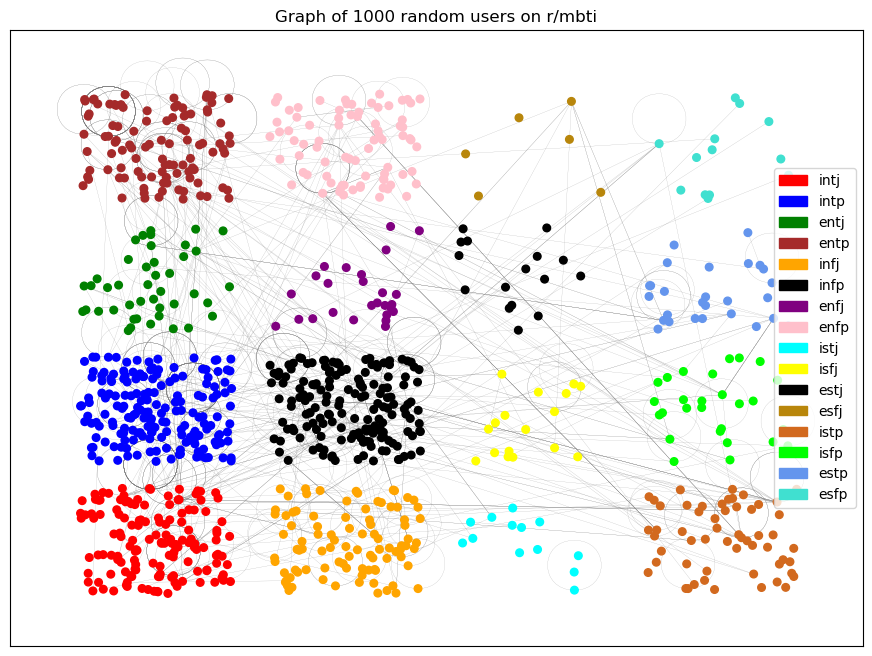

In [44]:
# Define node positions in a 4x4 grid for each flair
def rand():
    return random.uniform(-0.4,0.4)
pos = {}
for node in UG.nodes():
    if UG.nodes[node]['flair'] == 'intj':
        pos[node] = (0+rand(),0+rand())
    elif UG.nodes[node]['flair'] == 'intp':
        pos[node] = (0+rand(),1+rand())
    elif UG.nodes[node]['flair'] == 'entj':
        pos[node] = (0+rand(),2+rand())
    elif UG.nodes[node]['flair'] == 'entp':
        pos[node] = (0+rand(),3+rand())
    elif UG.nodes[node]['flair'] == 'infj':
        pos[node] = (1+rand(),0+rand())
    elif UG.nodes[node]['flair'] == 'infp':
        pos[node] = (1+rand(),1+rand())
    elif UG.nodes[node]['flair'] == 'enfj':
        pos[node] = (1+rand(),2+rand())
    elif UG.nodes[node]['flair'] == 'enfp':
        pos[node] = (1+rand(),3+rand())
    elif UG.nodes[node]['flair'] == 'istj':
        pos[node] = (2+rand(),0+rand())
    elif UG.nodes[node]['flair'] == 'isfj':
        pos[node] = (2+rand(),1+rand())
    elif UG.nodes[node]['flair'] == 'estj':
        pos[node] = (2+rand(),2+rand())
    elif UG.nodes[node]['flair'] == 'esfj':
        pos[node] = (2+rand(),3+rand())
    elif UG.nodes[node]['flair'] == 'istp':
        pos[node] = (3+rand(),0+rand())
    elif UG.nodes[node]['flair'] == 'isfp':
        pos[node] = (3+rand(),1+rand())
    elif UG.nodes[node]['flair'] == 'estp':
        pos[node] = (3+rand(),2+rand())
    elif UG.nodes[node]['flair'] == 'esfp':
        pos[node] = (3+rand(),3+rand())

# Draw graph
plt.figure(figsize=(11,8))
nx.draw_networkx(UG,pos=pos,node_color=node_colors,node_size=node_sizes, with_labels=False,edge_color='grey',width=0.1)
plt.legend(handles=[mpatches.Patch(color=color, label=flair) for flair, color in flair_colors.items()],loc='right')
plt.title("Graph of 1000 random users on r/mbti")
plt.show()

We have made a histogram over the personality types in the Reddit group. 
As seen in the figure the personality type that is mostly active is INTP, while the personality type who is less active is ESFJ. 

The description of each letter in the personality types are the following: 
N: Intuitiv
T: Thinking
F: Feeling
S: Observant
J: Judging
P: Prospecting
I: Introvert
E: Extrovert

So the above will describe the five personality aspects, when combined defines the personality types. 

With I, is normally introverted individuals who gets exhausted by social interaction and often get sensitive to external stimulations. 

While E, is normally extroverted individuals, who prefer being in groups and get's energy by social interactions. 

S, is the observants and they are practial and down to earth. 

N is intuitive individuals, they are imaginative and open-minded and curious. 

T is thinking, they focus on rationality and prioritize logic over emotions.

F is feeling individuals, and they are sensitive and emotionally expressive. 

J is judging individuals, they are highly organized and value clarity and structure. 

P is prospecting, and they are very good at improvising and spotting oppurtinities. 


INTP personality type is known as the logician, and has the 4 aspects I, N, T, P. 
So overall you can describe them as introverted, intuitve, thinking perople and prosecting people, while the ESFJ, has the aspects E, S, F, J, where you can descripe them as extroverted, observant, emotionally expressive and judging people. They are the obesite of the personality type who is mostly active in the group MBTI. 

The reasoning behind this could be, that the people who mostly have the aspect E are more often in social interaction rather than solitary activities, meaning that they are not home as much as the people with the aspect I. I are defined as introverts and often more home, and infront of the computer. AKA more active online than at social gatherings.

Bibliography:
https://www.16personalities.com/articles/our-theory